In [1]:
# 1. import module

import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pycaret.regression import *

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import KFold

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_seq_items = None



from py_module.load_data import load_data
from py_module.plot_data import plot_histogram
from py_module.regression import *
from py_module.pre_processing import *
from py_module.verify import *
from py_module.etc import *
from py_module.compare import *


In [3]:
# 2. data import

#raw_data = np.loadtxt("../data/leakage_inductance_20220608_105250_N14182.csv",delimiter=",")
#raw_data = np.loadtxt("../data/leakage_inductance_20220609_130342_N39022.csv",delimiter=",")
#raw_data = np.loadtxt("../data/leakage_inductance_20220610_132219_N61963.csv",delimiter=",")
raw_data = np.loadtxt("../data/leakage_inductance_20220612_122001_N106319.csv",delimiter=",")

#raw_data = np.loadtxt("../data/coupling.csv",delimiter=",")
#raw_data = np.loadtxt("../data/loss.csv",delimiter=",")

column_names = ["N1","w1","l1","l2","h1","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2","freq","Llt","Llr"]
#column_names = ["width0","width1","height0","height1","move","coil0_width","coil1_width","gap0","gap1","freq","k12","k13","k23"]
#column_names = ["width0","width1","height0","height1","move","coil0_width","coil1_width","gap0","gap1","0","freq","loss1","loss2","loss3"]

pd_data = pd.DataFrame(raw_data, columns=column_names)

pd_data = pd_data[pd_data["Llt"]<300]

#pd_data = pd_data[pd_data["N1"]==10]

pd_data.head()


,N1,w1,l1,l2,h1,space1,space2,space3,space4,coil_width1,coil_width2,move_z1,move_z2,offset_z1,offset_z2,freq,Llt,Llr
0,5.0,80.0,25.0,90.0,131.0,18.0,28.0,12.0,40.0,8.0,4.0,3.0,3.0,-9.5,-13.0,30.0,8.712074,8.786982
1,13.0,25.0,15.0,98.0,128.0,48.0,46.0,16.0,40.0,3.0,4.0,1.0,3.0,-5.0,-2.5,30.0,42.124680,39.919564
2,15.0,175.0,20.0,82.0,216.0,32.0,42.0,12.0,6.0,7.5,6.5,3.0,5.0,1.5,4.5,30.0,68.673984,68.700460
3,9.0,115.0,25.0,98.0,151.0,42.0,34.0,32.0,44.0,5.5,9.0,3.0,2.0,7.0,-19.5,30.0,29.187141,29.046585
4,9.0,160.0,50.0,70.0,114.0,36.0,6.0,50.0,40.0,7.0,2.5,2.5,5.0,-2.5,-18.0,30.0,41.889611,41.979255


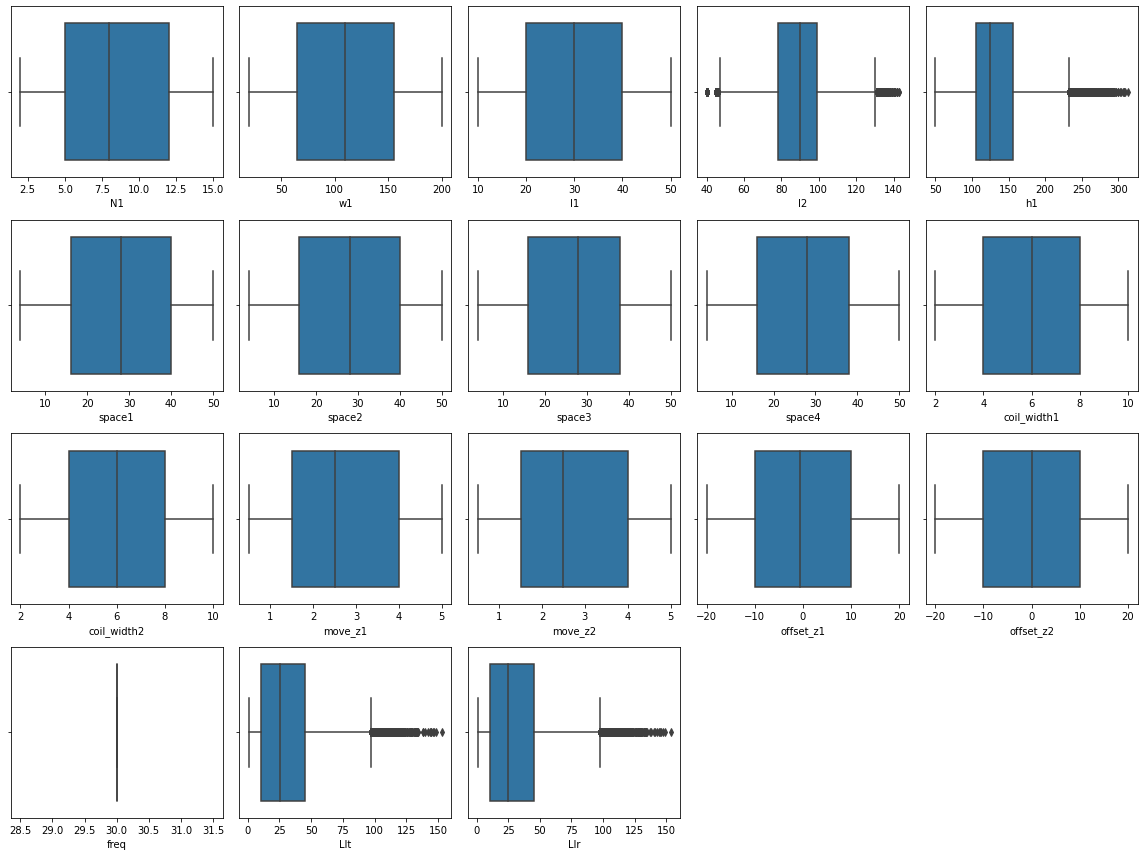

In [4]:
# 4. check outlier

plt.figure(figsize=(16, 12))
for i, colName in enumerate(list(pd_data.columns)) :
    plt.subplot(4, 5, i+1)
    sns.boxplot(x=pd_data.loc[:, colName])
plt.tight_layout()
plt.show()

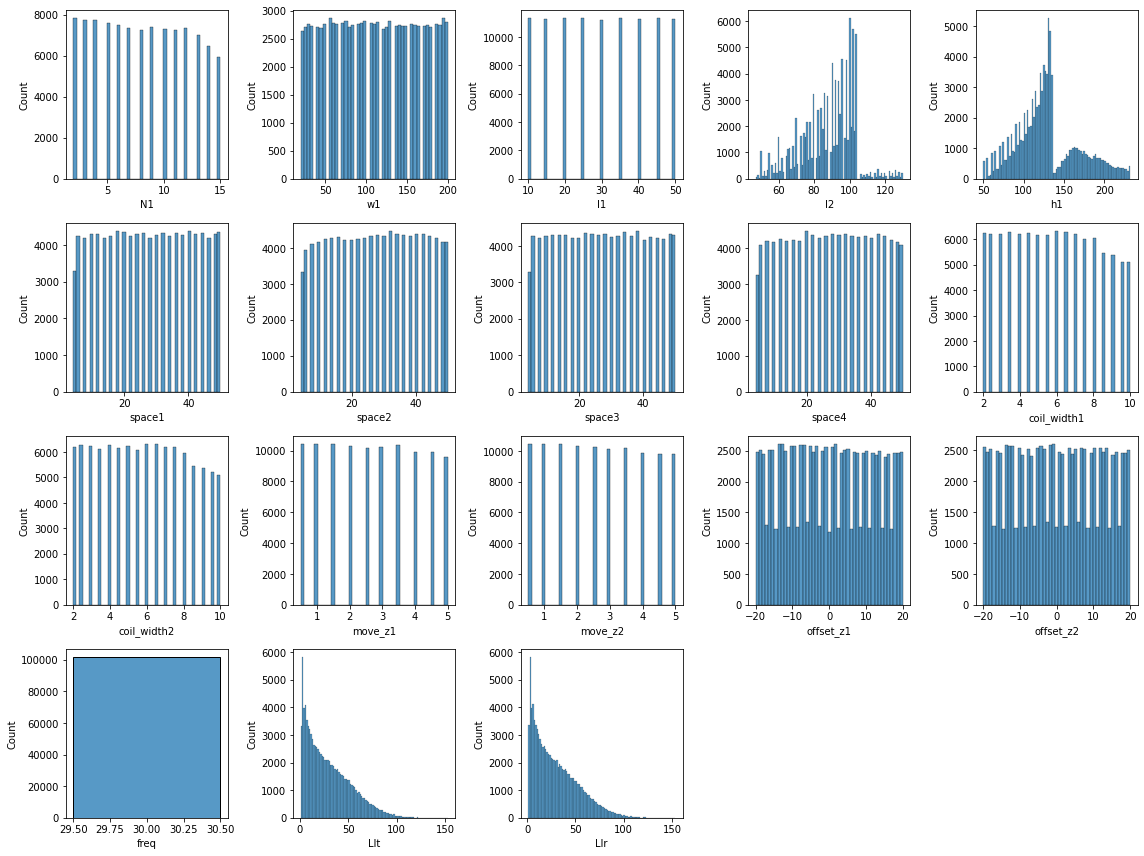

In [7]:
# 5. check data distribution

plt.figure(figsize=(16, 12))
for i, colName in enumerate(list(pd_data.columns)) :
    plt.subplot(4, 5, i+1)
    sns.histplot(pd_data.loc[:, colName])
plt.tight_layout()
plt.show()

In [5]:
min(pd_data["offset_z1"])

-20.0

In [6]:
# 7. define outlier search function
def get_outlier(df=None, column=None, weight=1.5):
    
    # column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    data = df[column]
    quantile_25 = np.percentile(data.values, 25)  # 1/4 분위
    quantile_75 = np.percentile(data.values, 75)  # 3/4 분위
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight  # 이상치 최소 기준
    highest_val = quantile_75 + iqr_weight # 이상치 최대 기준
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = data[(data < lowest_val) | (data > highest_val)].index
    
    return outlier_index

col_input = list(pd_data.columns)[:-3]
#col_input = list(pd_data.columns)

# outlier 탐색 및 제거
outlier_index = {}
for i, colName in enumerate(col_input):
     outlier_index[i] = get_outlier(df=pd_data, column=f'{colName}', weight=1.5)
outlier_index

# 각각의 숫자들 리스트 안에 넣기
outlier_list = []
for i in range(len(outlier_index)):
    if list(outlier_index[i].values) == []:
        continue
    outlier_list.append(list(outlier_index[i].values))


# 리스트 안의 리스트들을 하나로 합치기
outlier_list = sum(outlier_list , [])
print('개수:', len(outlier_list))

# 중복 숫자 제거
outlier_list = set(outlier_list)
print('개수:', len(outlier_list))

# 다시 리스트 타입으로 변환
outlier_list = list(outlier_list)
print(type(outlier_list))

# 리스트 숫자 정렬
outlier_list.sort()

# outlier를 갖는 index에 해당하는 data drop
for i in outlier_list:
    pd_data.drop(i, axis=0, inplace=True)
pd_data.shape

개수: 4593
개수: 4547
<class 'list'>


(101766, 18)

In [7]:
col_input

['N1',
 'w1',
 'l1',
 'l2',
 'h1',
 'space1',
 'space2',
 'space3',
 'space4',
 'coil_width1',
 'coil_width2',
 'move_z1',
 'move_z2',
 'offset_z1',
 'offset_z2',
 'freq',
 'Llt',
 'Llr']

In [8]:
# split input/output

X = pd_data.drop(columns="freq").drop(columns="Llt").drop(columns="Llr")
Y = pd_data["Llt"]

#X = pd_data.drop(columns="k12").drop(columns="k13").drop(columns="k23")
#Y = pd_data["k12"]

#X = pd_data.drop(columns="loss1").drop(columns="loss2").drop(columns="loss3")
#Y = pd_data["loss1"]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 765)

In [17]:
model = LGBMRegressor(random_state=765, n_estimators=200, learning_rate=0.05, num_leaves=31)
model.fit(X_train,Y_train)

print(model)

LGBMRegressor(learning_rate=0.05, n_estimators=200, random_state=765)


[0.9194803768383224, 1.4739470035896722, 3.4119400859955236, 1.8471437643008526, 6.128994562266139, -0.06535345386078947]
[0.9086330314832742, 1.6777340004740775, 4.80627263461419, 2.192321289093866, 6.86284814865819, -0.2010074420561903]
[0.9093933602509335, 1.525520525937093, 4.424739283312839, 2.1035064257835865, 5.98484565465967, -0.44664844244348284]
[0.9188752229607534, 1.4575326548984608, 3.927673271193973, 1.9818358335629047, 6.1927703882149014, -0.9260238859302794]
[0.9245603710022015, 1.3079331642324554, 3.355251022563842, 1.831734430140964, 5.718297909231998, -1.7402747485437224]


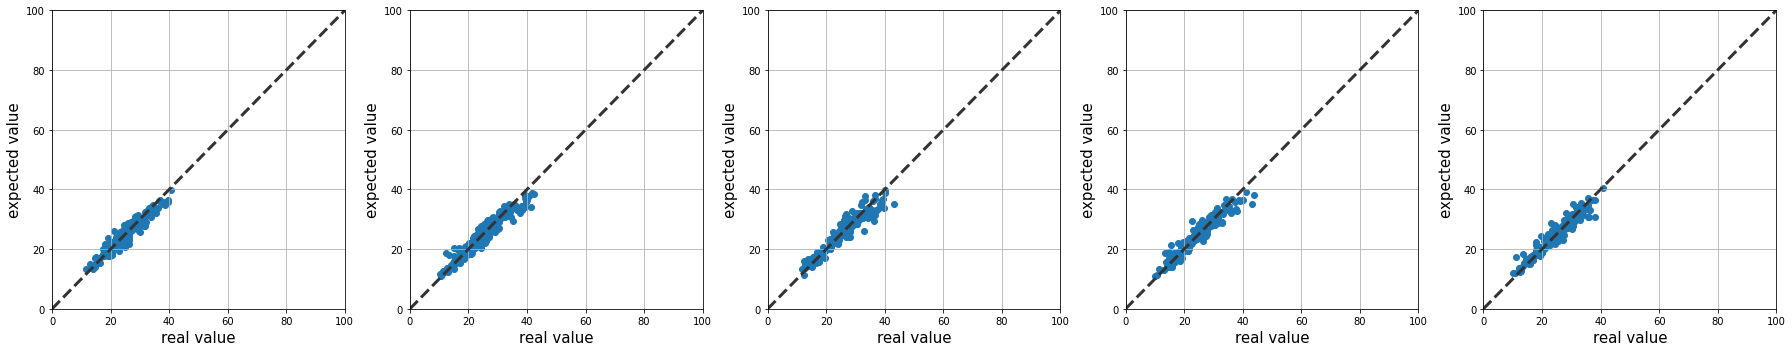

In [10]:
col_input = list(X.columns)

# 교차 검증용 데이터셋 구성
df_trains = []
df_valids = []

# MAPE 정의
def def_MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

# MPE 정의
def def_MPE(y_test, y_pred): 
	return np.mean((y_test - y_pred) / y_test) * 100

# KFold 검증
i = 0
plt.figure(figsize=(25, 5))
kfold = KFold(n_splits=5, random_state=765, shuffle=True)
for train_idx, test_idx in kfold.split(X[col_input]):

    # fold 후 train, test set 분할
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # regression model 생성
    model.fit(X_train, Y_train)

    # 예측
    fold_pred = model.predict(X_test)

    # 성능계산
    R2 = r2_score(Y_test, fold_pred)
    MAE = mean_absolute_error(Y_test, fold_pred)
    MSE = mean_squared_error(Y_test, fold_pred)
    RMSE = np.sqrt(MSE)
    MAPE = def_MAPE(Y_test, fold_pred)
    MPE = def_MPE(Y_test, fold_pred)

    print([R2, MAE,MSE,RMSE,MAPE,MPE])

    plt.subplot(1, 5, i+1)
    plt.scatter(Y_test, fold_pred)
    plt.xlabel("real value", fontsize=15)
    plt.ylabel("expected value", fontsize=15)
    plt.grid(True)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.plot([0, 100], [0, 100], ls="--", c=".2", linewidth=3.0)
    i = i+1

plt.tight_layout()
plt.show()

In [11]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "n_estimators" : [1000,3000,10000],
    'n_jobs' : [-1],
    'learning_rate': [0.05],
    'max_depth' : [-1,2,3,4,5,10,20,30,50],
    'num_leaves' : [31,60,80,100,127],
    }

#cv=5 5번의 교차검증.
grid = GridSearchCV(LGBMRegressor(random_state=0), verbose=2, param_grid = parameters, cv=kfold)
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   0.5s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   0.5s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   0.5s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   0.5s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   0.5s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=60 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=60, total=   0.5s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=60 


KeyboardInterrupt: 

In [ ]:
grid.best_params_

{'learning_rate': 0.05,
 'max_depth': 4,
 'n_estimators': 10000,
 'n_jobs': -1,
 'num_leaves': 31}

In [12]:
#model = LGBMRegressor(random_state=765, learning_rate=0.05, max_depth=10, n_estimators=5000)
tuned_model = LGBMRegressor(random_state=765, **grid.best_params_)
tuned_model.fit(X_train,Y_train)

print(tuned_model)

NameError: name 'grid' is not defined

[0.9958255566144492, 0.9140250937075481, 1.9941484544223416, 1.4121432131417626, 4.949711517847335, 0.002318099733269799]
[0.9954067757918389, 0.9500328800056479, 2.252135805418638, 1.5007117662691387, 4.881763796540582, -0.028577398065501528]
[0.995688961094157, 0.9443259502352217, 2.068698070153125, 1.4382969339302385, 4.961097882169882, -0.3890619051306933]
[0.9963029117734534, 0.889377177241239, 1.8267548140643102, 1.3515749383827411, 5.032781846390559, -0.016524105625636925]
[0.9957007888645959, 0.9235714194097383, 2.0459684638366453, 1.430373539966622, 5.003386000144607, -0.17458481899094844]


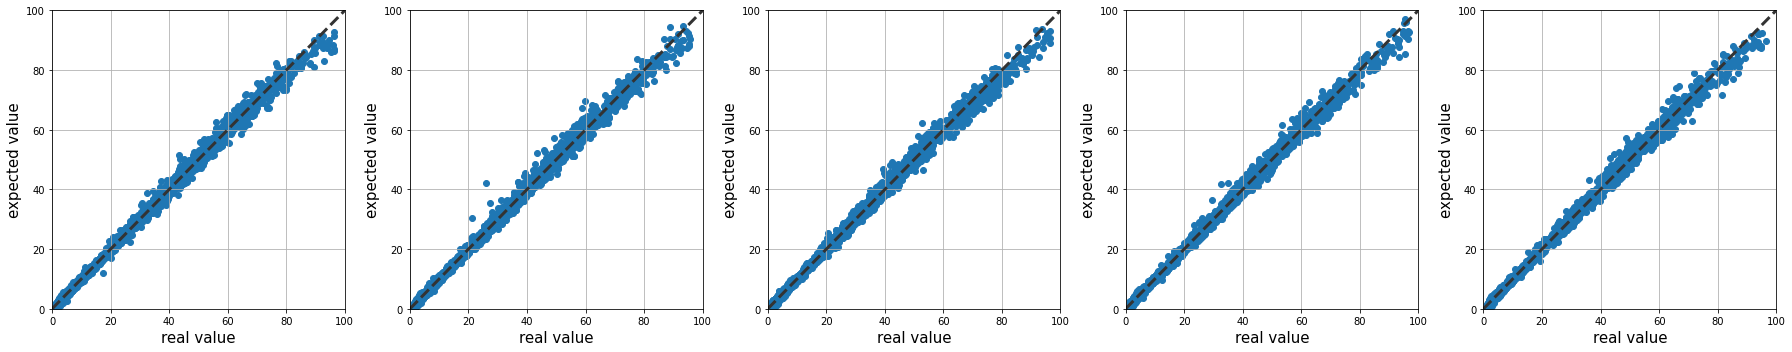

In [ ]:
# 교차 검증용 데이터셋 구성
df_trains = []
df_valids = []

# MAPE 정의
def def_MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

# MPE 정의
def def_MPE(y_test, y_pred): 
	return np.mean((y_test - y_pred) / y_test) * 100

# KFold 검증
i = 0
plt.figure(figsize=(25, 5))
kfold = KFold(n_splits=5, random_state=765, shuffle=True)
for train_idx, test_idx in kfold.split(X[col_input]):

    # fold 후 train, test set 분할
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # regression model 생성
    tuned_model.fit(X_train, Y_train)

    # 예측
    fold_pred = tuned_model.predict(X_test)

    # 성능계산
    R2 = r2_score(Y_test, fold_pred)
    MAE = mean_absolute_error(Y_test, fold_pred)
    MSE = mean_squared_error(Y_test, fold_pred)
    RMSE = np.sqrt(MSE)
    MAPE = def_MAPE(Y_test, fold_pred)
    MPE = def_MPE(Y_test, fold_pred)

    print([R2, MAE,MSE,RMSE,MAPE,MPE])

    plt.subplot(1, 5, i+1)
    plt.scatter(Y_test, fold_pred)
    plt.xlabel("real value", fontsize=15)
    plt.ylabel("expected value", fontsize=15)
    plt.grid(True)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.plot([0, 100], [0, 100], ls="--", c=".2", linewidth=3.0)
    i = i+1

plt.tight_layout()
plt.show()

In [18]:
train_data = pd.concat([X_train,pd.DataFrame(Y_train)], axis=1)

test_data = pd.concat([X_test,pd.DataFrame(Y_test)], axis=1)


train_data.head()

,N1,w1,l1,l2,h1,space1,space2,space3,space4,coil_width1,coil_width2,move_z1,move_z2,offset_z1,offset_z2,Llt
7496,8.0,50.0,20.0,98.0,132.0,34.0,46.0,50.0,18.0,10.0,8.5,2.5,1.5,7.5,-4.5,17.264659
61828,3.0,160.0,35.0,77.0,63.0,42.0,36.0,4.0,14.0,4.0,8.0,5.0,1.5,-18.0,-14.0,6.008307
15005,3.0,35.0,35.0,78.0,75.0,18.0,28.0,10.0,22.0,7.0,6.0,4.5,1.5,6.5,2.5,2.962115
67553,7.0,200.0,20.0,74.0,130.0,16.0,18.0,28.0,20.0,2.0,8.5,1.5,3.5,6.5,14.5,25.353995
59234,11.0,175.0,10.0,98.0,132.0,22.0,36.0,10.0,22.0,6.0,3.5,1.0,2.5,-5.5,-16.5,46.459656


In [13]:
parameter = "Llt"

verify_plot(tuned_model, train_data, test_data, parameter, xlim=[0,100], ylim=[0,100], legend=True)

NameError: name 'tuned_model' is not defined

array([0.99200754, 1.3023921 , 4.25719936, 2.06329817, 6.17794284])

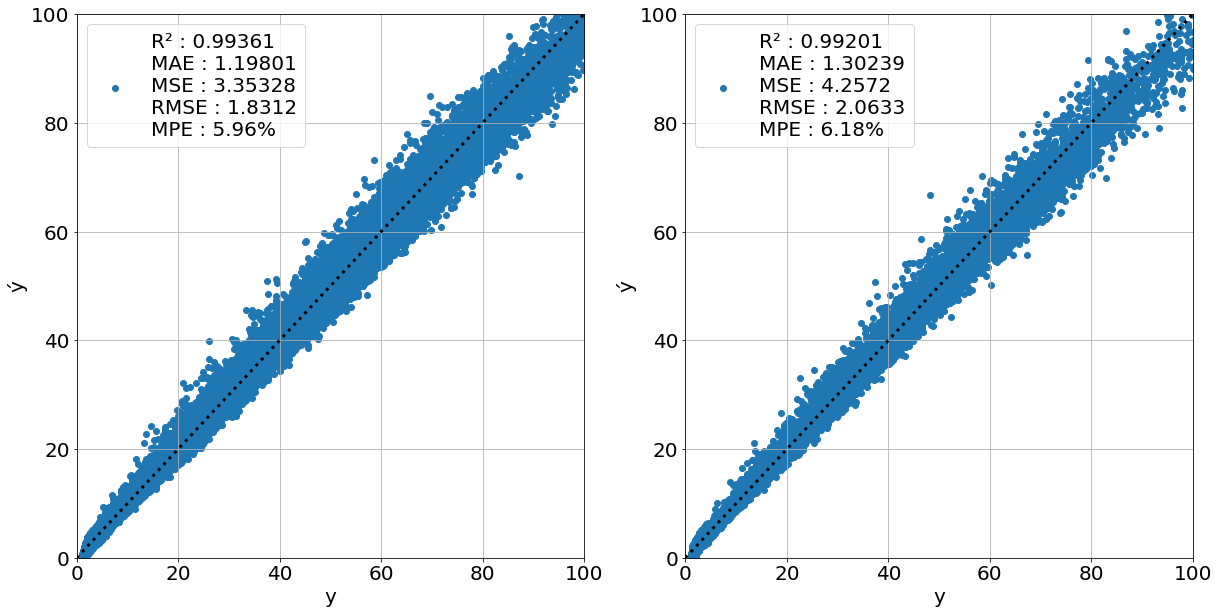

In [19]:
parameter = "Llt"

verify_plot(model, train_data, test_data, parameter, xlim=[0,100], ylim=[0,100], legend=True)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

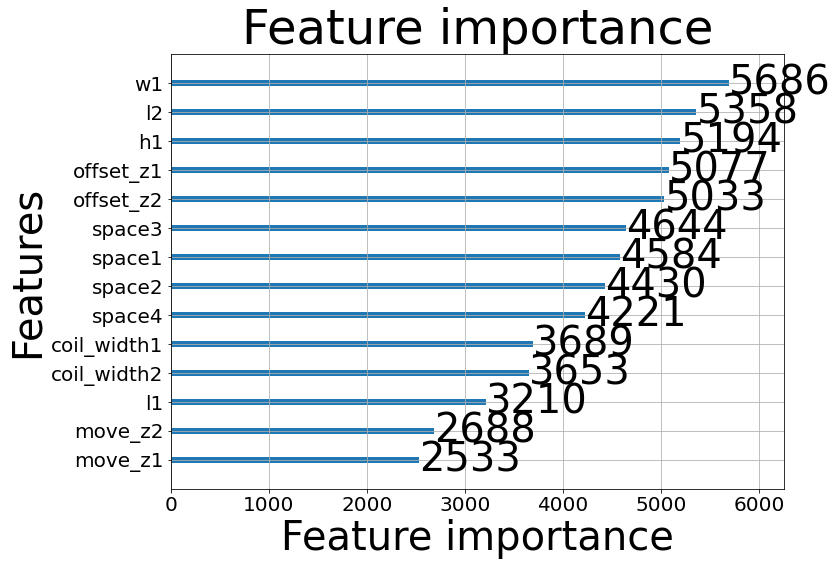

In [48]:
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize=(11,8))
plot_importance(model, ax)

In [20]:
import joblib

joblib.dump(model, 'leakage_inductance_0612.pkl')

['leakage_inductance_0612.pkl']

In [14]:
import joblib

load_model = joblib.load('leakage_inductance.pkl')

array([0.99570079, 0.92357142, 2.04596846, 1.43037354, 5.003386  ])

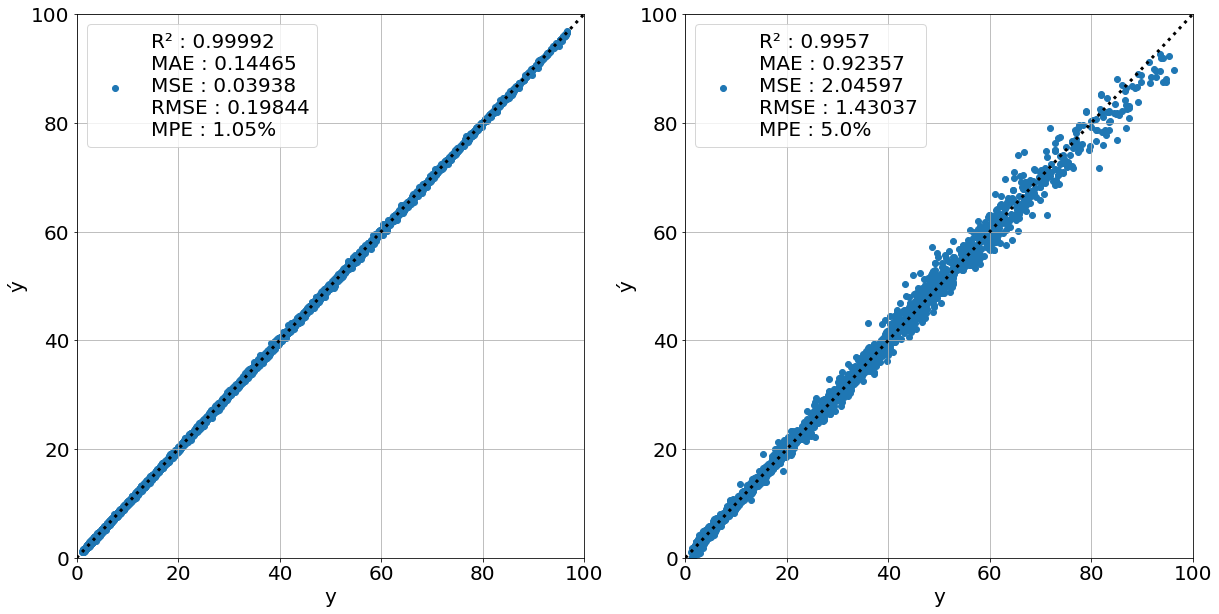

In [ ]:
verify_plot(load_model, train_data, test_data, parameter, xlim=[0,100], ylim=[0,100], legend=True)

In [21]:
import joblib

load_model = joblib.load('leakage_inductance_0612.pkl')
# 
predict_data = [[12,50,15,60,70,15,15,5,5,4,4,0.5,0.5,0,0]]
predict_data = [[10,43,28,101,81,24,24,12,10,4,5,1,2,8,0]]
predict_data = [[12,31,13,90,94,24,23,11,10,3,4,1,3,12,0]]

predict_column = ["N1","w1","l1","l2","h1","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2"]

predict_data = pd.DataFrame(predict_data, columns=predict_column)


predict_data

load_model.predict(predict_data)


#8.0	95.0	30.0	90.0	97.0	34.0	48.0	24.0	10.0	2.0	5.0	2.0	1.5	13.5	3.0	30.0	30.324413	30.089349

array([31.65269621])

In [24]:
[[N1,w1,l1,l2,h1,space1,space2,space3,space4,coil_width1,coil_width2,move_z1,move_z2,offset_z1,offset_z2]] = [[12,31,13,90,94,24,23,11,10,3,4,1,3,12,0]]

height = max(N1*coil_width1 + (N1-1)*move_z1 + 2*abs(offset_z1), N1*coil_width2 + (N1-1)*move_z2 + 2*abs(offset_z2))

h1_range = [50, 130, 5, 0]

if height>h1_range[0] and height<h1_range[1] :
    h1_range = [height+5,h1_range[1],h1_range[2],h1_range[3]]
if height>h1_range[0] and height>h1_range[1] :
    h1_range = [height+5,height*1.2,h1_range[2],h1_range[3]]



print(height)
print(h1_range)

81
[86, 130, 5, 0]


In [28]:
# 2. data import

#raw_data = np.loadtxt("../data/leakage_inductance_20220608_105250_N14182.csv",delimiter=",")
#raw_data = np.loadtxt("../data/leakage_inductance_20220609_130342_N39022.csv",delimiter=",")
search_data = np.loadtxt("../data/leakage_inductance_20220612_122001_N106319.csv",delimiter=",")
search_data = np.loadtxt("../data/loss_20220612_122001_N106322.csv",delimiter=",")
#raw_data = np.loadtxt("../data/coupling.csv",delimiter=",")
#raw_data = np.loadtxt("../data/loss.csv",delimiter=",")

#column_names = ["N1","w1","l1","l2","h1","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2","freq","Llt","Llr"]
column_names = ["N1","w1","l1","l2","h1","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2","null","freq","loss_tx","loss_rx"]

search_data = pd.DataFrame(search_data, columns=column_names)

search_data = search_data[search_data["N1"] == 12]
search_data = search_data[(search_data["w1"] >= 30) & (search_data["w1"] <= 35)]
search_data = search_data[(search_data["l1"] >= 10) & (search_data["l1"] <= 15)]
search_data = search_data[(search_data["l2"] >= 90) & (search_data["l2"] <= 95)]
#search_data = search_data[(search_data["h1"] >= 80) & (search_data["h1"] <= 85)]

print(search_data.shape)
search_data

#[[12,30,10,94,190,10,38,16,10,5.5,10,0.5,2.5,-18,-19]]

(14, 19)


,N1,w1,l1,l2,h1,space1,space2,space3,space4,coil_width1,coil_width2,move_z1,move_z2,offset_z1,offset_z2,null,freq,loss_tx,loss_rx
7491,12.0,30.0,10.0,94.0,190.0,10.0,38.0,16.0,10.0,5.5,10.0,0.5,2.5,-18.0,-19.0,0.0,30.0,106.319698,66.863176
12187,12.0,35.0,15.0,93.0,132.0,14.0,22.0,30.0,16.0,4.0,6.0,4.5,3.5,15.0,-3.5,0.0,30.0,72.421084,60.858034
16182,12.0,30.0,15.0,90.0,126.0,34.0,24.0,46.0,10.0,3.5,3.0,2.0,4.5,5.5,-5.0,0.0,30.0,122.015329,125.843406
20305,12.0,35.0,15.0,93.0,181.0,40.0,18.0,28.0,44.0,9.0,7.0,1.0,2.0,18.5,-0.5,0.0,30.0,113.958653,89.097709
46306,12.0,35.0,10.0,90.0,160.0,48.0,18.0,32.0,30.0,8.5,3.0,0.5,3.0,11.5,-18.0,0.0,30.0,120.796756,133.365224
60118,12.0,30.0,10.0,93.0,170.0,38.0,4.0,10.0,28.0,6.0,10.0,0.5,0.5,-15.0,17.0,0.0,30.0,131.560118,78.905283
80284,12.0,30.0,15.0,92.0,186.0,6.0,18.0,48.0,40.0,9.5,4.5,4.5,4.0,1.5,1.5,0.0,30.0,59.098200,112.568676
90062,12.0,30.0,15.0,90.0,162.0,32.0,28.0,10.0,12.0,9.0,6.5,2.5,3.0,8.0,8.5,0.0,30.0,82.813140,62.041733
91593,12.0,30.0,15.0,95.0,132.0,34.0,32.0,48.0,50.0,3.0,5.0,2.0,2.5,8.0,20.0,0.0,30.0,164.771028,162.359198
93050,12.0,30.0,15.0,90.0,145.0,50.0,24.0,50.0,26.0,3.5,7.0,3.5,1.0,-18.5,-20.0,0.0,30.0,138.431865,125.106715
